In [2]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties

sns.set_style("whitegrid")

### Define static values and load data

In [3]:
# Baseline was estimate using randomly_shuffled_evaluation.py (run 10 x)
baseline = dict({
    "accuracy": 0.2501,
    "kappa": 0.0174,
    "f1-score": 0.1717
})

metrics = ["accuracy", "kappa", "f1-score"]
boxplot_kwargs = {"boxprops": dict(alpha=0.5), "fliersize": 3}
font_properties = FontProperties(style='italic')
modes = ["central", "federated", "z_local_all"]

In [4]:
def add_local_all(df):
    """
    Add all local runs to one new column in the given df
    """
    local_rows = df[df["mode"].str.contains("TMA|spl")].copy()
    local_rows["mode"] = "z_local_all" # adding prefix z_* to place as last bar in plots
    df = pd.concat([df, local_rows], ignore_index=True)
    return df

In [5]:
folder = "run_results"
homo_df = add_local_all(pd.read_csv(os.path.join(folder, "homogeneous.csv")))
hetero_df = add_local_all(pd.read_csv(os.path.join(folder, "heterogeneous.csv")))
TMA_df = add_local_all(pd.read_csv(os.path.join(folder, "TMA.csv")))

homo_df["dataset"] = "homogeneous"
hetero_df["dataset"] = "heterogeneous"
TMA_df["dataset"] = "TMA"
full_df = pd.concat([homo_df, hetero_df, TMA_df], ignore_index=True)

### Compare centralized, federated, and local for equal data

In [6]:
def calc_mean(df):
    equal_means_dict = dict({m: list() for m in metrics})
    grouped = df.groupby("mode")
    for mode, group in grouped:
        if True:
            print(f"\n{mode}")
            print(" ".join(metrics))
            for metric in metrics:
                mean = group[metric].mean()
                equal_means_dict[metric].append(mean)
                print(f"{mean:.3}", end="\t")
            print()

    return equal_means_dict

equal_means_dict = calc_mean(homo_df)


central
accuracy kappa f1-score
0.529	0.709	0.444	

federated
accuracy kappa f1-score
0.511	0.708	0.448	

spl_1
accuracy kappa f1-score
0.488	0.669	0.409	

spl_2
accuracy kappa f1-score
0.503	0.668	0.422	

spl_3
accuracy kappa f1-score
0.51	0.685	0.427	

z_local_all
accuracy kappa f1-score
0.5	0.674	0.419	


In [7]:
def best_epochs(df):
    print("mean best epoch per mode:")
    for mode in df["mode"].unique():
        m_df = df[df["mode"] == mode]
        fill = "\t\t" if mode[:3] == "TMA" else "\t"
        print(f"{mode}{fill}{round(m_df['best_epoch'].mean())}")

best_epochs(homo_df)

mean best epoch per mode:
central	320
federated	427
spl_1	410
spl_2	375
spl_3	414
z_local_all	400


## Figure 4

In [8]:

import itertools
from scipy.stats import kruskal

In [9]:
def get_p_value_symbol(p: float)-> str:
    '''
        Indicates the statistical significance by strings. Is used for plots.
        :param p: p-value of the test

        :return: string indicating the significance level
    '''
    if p < 0.0001:
        return "***"
    elif p < 0.01:
        return "** "
    elif p < 0.05:
        return " * "
    else:
        return ""
    
def add_stats(df, metric, factor, ax):
    h_base = max(df[metric].values)
    for x, dataset in enumerate(["homogeneous", "heterogeneous", "TMA"]):
        t_df = df[df["dataset"] == dataset][["mode", metric]]
        h = h_base + factor * 2
        for mode1, mode2 in itertools.combinations(modes, 2):
            data1 = t_df[t_df["mode"] == mode1][metric].values
            data2 = t_df[t_df["mode"] == mode2][metric].values
            _, p_value = kruskal(data1, data2)

            symbol = get_p_value_symbol(p_value)
            if symbol != "":
                l = -0.3 if mode1 == "central" else 0.0
                r = 0.3 if mode2 == "z_local_all" else 0.0
                ax.text(((x+l) + (x+r))/2, h, symbol, ha="center", va="center")
                ax.plot([x+l, x+r], [h, h], c="black", lw=1)
                ax.plot([x+l, x+l], [h, h-factor], c="black", lw=1)
                ax.plot([x+r, x+r], [h, h-factor], c="black", lw=1)
            h = h + factor * 3

/tmp/ipykernel_10949/2886870231.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)
/tmp/ipykernel_10949/2886870231.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)
/tmp/ipykernel_10949/2886870231.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)


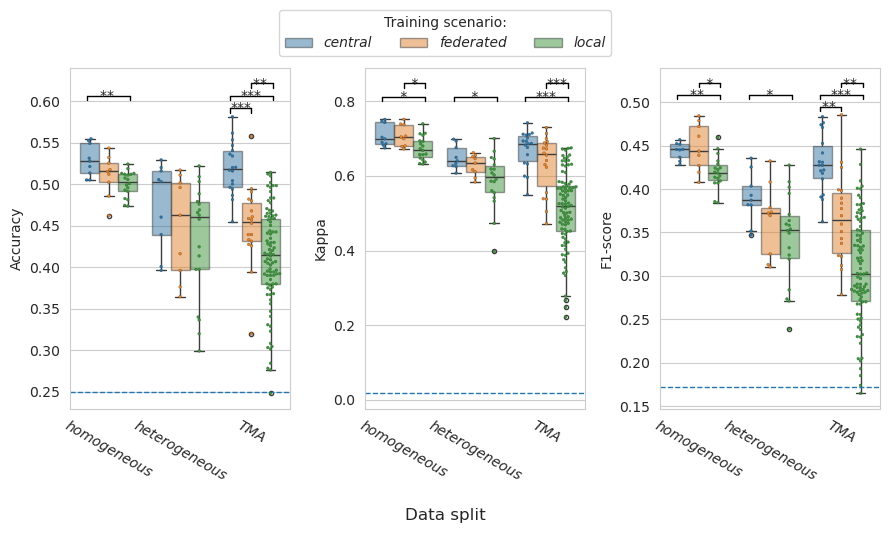

In [10]:
def create_figure4(df):
    df=df[df["mode"].isin(modes)]
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    factors = [0.005, 0.012, 0.0045]
    for i, metric in enumerate(metrics):
        sns.boxplot(x="dataset", y=metric, hue="mode", dodge=True, data=df, ax=axes[i], **boxplot_kwargs)
        sns.swarmplot(x="dataset", y=metric, hue="mode", dodge=True, data=df, ax=axes[i], edgecolor="auto", linewidth=0.2, size=2)
        add_stats(df, metric, factors[i], axes[i])

        axes[i].axhline(baseline[metric], linestyle="--", linewidth=1)
        axes[i].set_xlabel("")
        axes[i].set_ylabel(f"{metric.capitalize()}")
        axes[i].legend().remove()
        axes[i].tick_params(axis="x", labelrotation=-30)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)


    fig.supxlabel("Data split")

    handles, labels = axes[0].get_legend_handles_labels()
    new_handles = [handles[0], handles[1], handles[2]]
    new_labels = [labels[0], labels[1], "local"]
    fig.legend(new_handles, new_labels, loc="upper center", title="Training scenario:", ncol=3, bbox_to_anchor=(0.5, 1.05), prop={'style': 'italic'})
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig(os.path.join("run_results", "Figure4.png"), dpi=300, bbox_inches="tight")
    
create_figure4(full_df)

/tmp/ipykernel_10949/1982934226.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)
/tmp/ipykernel_10949/1982934226.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)
/tmp/ipykernel_10949/1982934226.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)


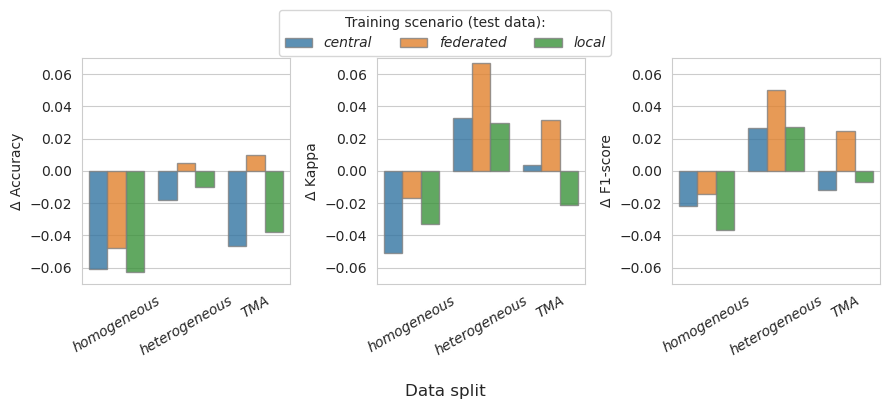

In [11]:
import numpy as np

def create_figure5(df):
    df = df[df["mode"].isin(modes)]
    fig, axes = plt.subplots(1, 3, figsize=(9, 4))
    y_min = 0.0
    y_max = 0.0
    for i, metric in enumerate(metrics):
        mean_values = df.groupby(["mode", "dataset"])[[metric, f"{metric}_TMA20"]].mean().reset_index()
        custom_order = ["homogeneous", "heterogeneous", "TMA"]
        mean_values["dataset"] = pd.Categorical(mean_values["dataset"], categories=custom_order, ordered=True)
        mean_values = mean_values.sort_values(by='dataset')
        mean_values["metric_diff"] = mean_values[f"{metric}_TMA20"] - mean_values[metric]
        sns.barplot(x="dataset", y="metric_diff", hue="mode", data=mean_values, ax=axes[i], edgecolor="grey", alpha=0.8)

        axes[i].set_xlabel("")
        axes[i].set_ylabel(f"\u0394 {metric.capitalize()}")
        axes[i].legend().remove()
        axes[i].tick_params(axis="x", labelrotation=30)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontproperties=font_properties)

        if y_min > min(mean_values["metric_diff"]):
            y_min = min(mean_values["metric_diff"])
        if y_max < max(mean_values["metric_diff"]):
            y_max = max(mean_values["metric_diff"])


    for i in range(len(metrics)):
        axes[i].set_ylim(np.floor(y_min * 100) / 100, np.ceil(y_max * 100) / 100)

    fig.supxlabel("Data split")
    handles, _ = axes[0].get_legend_handles_labels()
    new_labels = ["central", "federated", "local"]
    fig.legend(handles, new_labels, loc="upper center", title="Training scenario (test data):", ncol=3, bbox_to_anchor=(0.5, 1.0), prop={'style': 'italic'})
    plt.tight_layout(rect=[0, 0, 1, 0.9])

    plt.savefig(os.path.join("run_results", "Figure5.png"), dpi=300, bbox_inches="tight")

create_figure5(full_df)

## Additonal evaluations

In [12]:
def compare_medians_external(df):
    """
        This function calculates the statistics that were used in the 'External testing of model performance' subsection.
    """
    splits = ["homogeneous", "heterogeneous", "TMA"]
    df = df[df["mode"].isin(modes)]
    grouped = df.groupby('mode')
    for mode, group in grouped:
        print(mode)
        for m in metrics:
            print(m)
            print("\t", end="")
            print('\t'.join(splits))
            print("\t", end="")
            for split in splits:
                data = group[group["dataset"] == split]
                mean = data[m].mean()
                mean_TMA20 = data[f"{m}_TMA20"].mean()
                diff = mean - mean_TMA20
                percentage = diff/mean*100

                print(f"{round(-percentage)}", end="\t\t")
            print()
        print()
        
    return

compare_medians_external(full_df)

central
accuracy
	homogeneous	heterogeneous	TMA
	-12		-4		-9		
kappa
	homogeneous	heterogeneous	TMA
	-7		5		1		
f1-score
	homogeneous	heterogeneous	TMA
	-5		7		-3		

federated
accuracy
	homogeneous	heterogeneous	TMA
	-9		1		2		
kappa
	homogeneous	heterogeneous	TMA
	-2		11		5		
f1-score
	homogeneous	heterogeneous	TMA
	-3		14		7		

z_local_all
accuracy
	homogeneous	heterogeneous	TMA
	-13		-2		-9		
kappa
	homogeneous	heterogeneous	TMA
	-5		5		-4		
f1-score
	homogeneous	heterogeneous	TMA
	-9		8		-2		



In [13]:
def direct_comparisions_to_local(df, dataset):
    """
        Calcualte the mean performance of central, federated, and local models.
        Then return the performance drop of the local model in percent.
        The data split to test needs to be defined.
    """
    t_df = df[df["dataset"] == dataset]

    cent = t_df[t_df["mode"] == "central"]
    fed = t_df[t_df["mode"] == "federated"]
    local = t_df[t_df["mode"] == "z_local_all"]
    
    results = list()
    for m in metrics:
        l_m = local[m].mean()
        c_m = cent[m].mean()
        f_m = fed[m].mean()

        l_f_diff = (f_m - l_m) / f_m*100
        l_c_diff = (c_m - l_m) / c_m*100
        results.extend([l_f_diff, l_c_diff])

    print(f"{dataset}\t{min(results):.0f}% - {max(results):.0f}%")
    return

direct_comparisions_to_local(full_df, "homogeneous")
direct_comparisions_to_local(full_df, "heterogeneous")
direct_comparisions_to_local(full_df, "TMA")

homogeneous	2% - 6%
heterogeneous	4% - 12%
TMA	9% - 28%


In [18]:
def performance_decline_FL(df):
    """
        Calcualte the performance decline of FL approach in non-IID settings.
        This information is used in the abstract of the manuscript.
    """
    t_df = df[df["mode"] == "federated"]


    ho_df = t_df[t_df["dataset"] == "homogeneous"]

    he_df = t_df[t_df["dataset"] == "heterogeneous"]
    T_df = t_df[t_df["dataset"] == "TMA"]
    
    
    results = list()
    for m in metrics:
        ho_m = ho_df[m].mean()
        he_m = he_df[m].mean()
        T_m = T_df[m].mean()

        ho_he_diff = (ho_m - he_m) / ho_m*100
        ho_T_diff = (ho_m - T_m) / ho_m*100
        results.extend([ho_he_diff, ho_T_diff])

    print(f"Average performance decline of the FL-based models when comparing homogenous data split to the two non-IID splits is {sum(results)/len(results):.3}%.")
    return

performance_decline_FL(full_df)

Average performance decline of the FL-based models when comparing homogenous data split to the two non-IID splits is 13.8%.


In [30]:
def performance_range(df, dataset):
    """
        Provide info about the performance range of the individual models.
        Takes the difference of the best and worst performing model as reference.
        Calcualtes the percentage of the difference to be comparable between metrics.
        Is used in the discussion of the manuscript.
    """
    def get_range(df, mode):
        t_df = df[df["mode"] == mode]
        results = list()
        
        for m in metrics:
            range = t_df[m].max() - t_df[m].min()
            perc = range / t_df[m].max() * 100
            results.append(perc)

        print(f"{mode} range\t{sum(results)/len(results):.2f}%")
        return

    t_df = df[df["dataset"] == dataset]
    
    print(dataset)
    get_range(t_df, "federated")
    get_range(t_df, "z_local_all")
    return

performance_range(full_df, "heterogeneous")
performance_range(full_df, "TMA")

heterogeneous
federated range	23.20%
z_local_all range	43.33%
TMA
federated range	40.19%
z_local_all range	60.66%


In [35]:
def heterogenoues_internal_comparision(df):
    t_df = df[df["dataset"] == "heterogeneous"]
    
    perc_diffs = list()
    for m in metrics:
        cl1 = t_df[t_df["mode"] == "spl_1"][m].mean()
        cl2 = t_df[t_df["mode"] == "spl_2"][m].mean()
        cl3 = t_df[t_df["mode"] == "spl_3"][m].mean()

        perc_diffs.append((cl2 - cl1) / cl2 * 100)
        perc_diffs.append((cl3 - cl1) / cl3 * 100)

    print(f"Local models trained on cohort 1 perform on average between {round(min(perc_diffs))}% and {round(max(perc_diffs))}% worse.")

heterogenoues_internal_comparision(full_df)

[25.962891910655976, 17.54731131447395, 19.38920161399233, 15.51262641453531, 21.943636640116388, 11.014197175264274]
Local models trained on cohort 1 perform on average between 11% and 26% worse.


# Supplementary figures

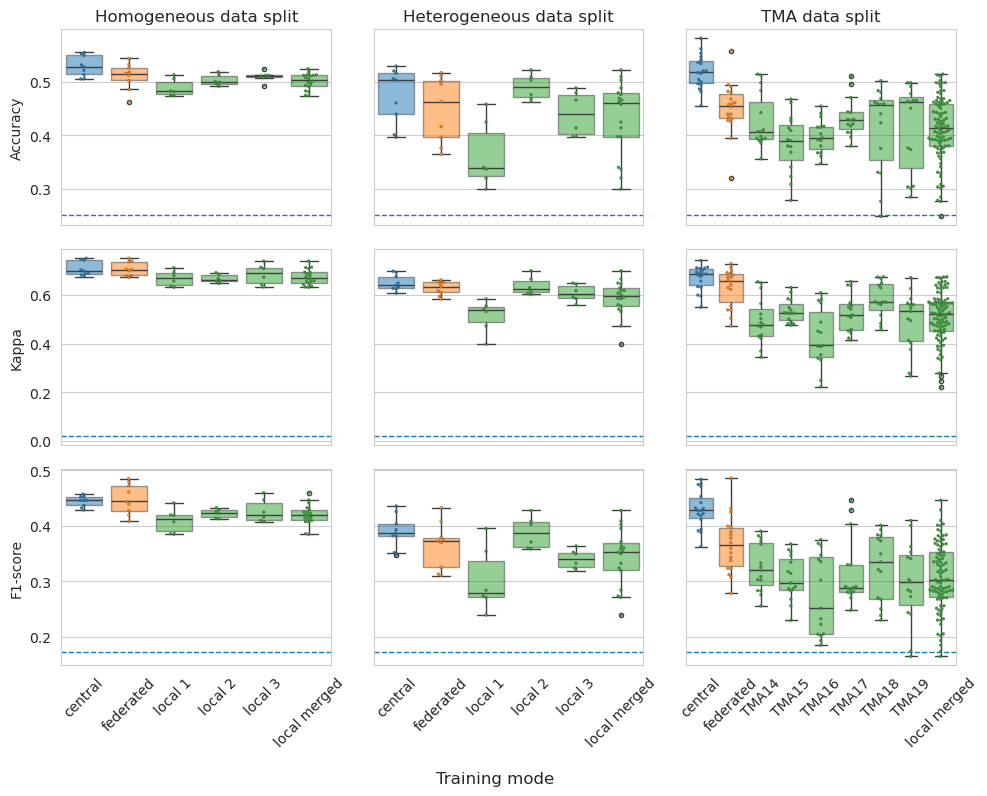

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

def plot_supp1(df, ax, metric, mode=""):
    if mode == "TMA":
        custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c"]
    else:
        custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c"]
            
    sns.boxplot(x='mode', y=metric, dodge=True, data=df, ax=ax, **boxplot_kwargs)
    for i, patch in enumerate(ax.patches):
        patch.set_facecolor(custom_colors[i])
    sns.swarmplot(x='mode', y=metric, data=df, ax=ax, palette=custom_colors, edgecolor="gray", linewidth=0.2, size=2)

    ax.axhline(baseline[metric], linestyle="--", linewidth=1)
    ax.set_xlabel("")
    ax.set_xticklabels([])

def create_suppfigure1(upper_df, middle_df, lower_df):
    fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharey="row")
    for i, metric in enumerate(metrics):
        plot_supp1(upper_df, axes[i][0], metric)
        plot_supp1(middle_df, axes[i][1], metric)
        plot_supp1(lower_df, axes[i][2], metric, mode="TMA")

        axes[i][0].set_ylabel(f"{metric.capitalize()}")

    axes[0][0].set_title("Homogeneous data split")
    axes[0][1].set_title("Heterogeneous data split")
    axes[0][2].set_title("TMA data split")
    
    axes[2][0].set_xticklabels(["central", "federated", "local 1", "local 2", "local 3", "local merged"], rotation=45)
    axes[2][1].set_xticklabels(["central", "federated", "local 1", "local 2", "local 3", "local merged"], rotation=45)
    axes[2][2].set_xticklabels(["central", "federated", "TMA14", "TMA15", "TMA16", "TMA17", "TMA18", "TMA19", "local merged"], rotation=45)
    
    fig.supxlabel("Training mode")
    plt.tight_layout()
    plt.savefig(os.path.join("run_results", "Supp_Figure1.png"), dpi=300)

create_suppfigure1(homo_df, hetero_df, TMA_df)

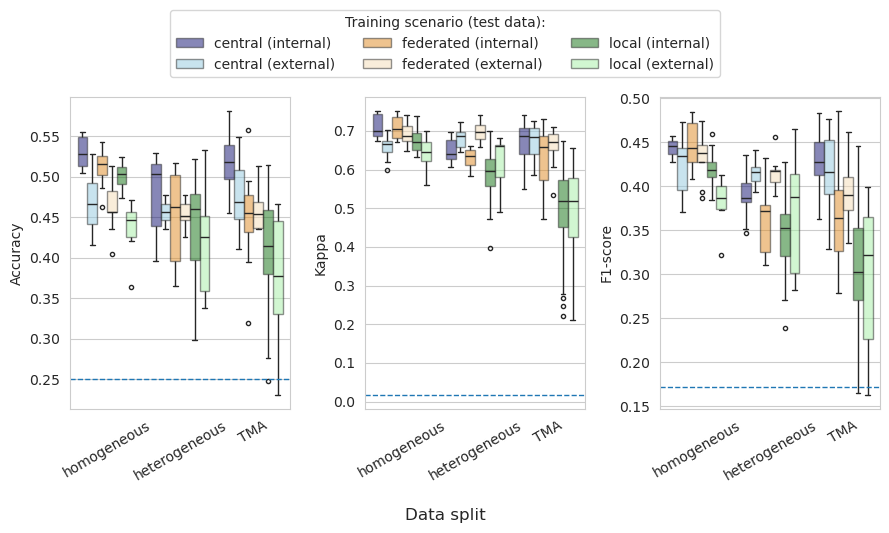

In [36]:
def create_suppfigure2(df):
    df = df[df["mode"].isin(modes)]
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    custom_colors = ["navy", "skyblue", "darkorange", "navajowhite", "green", "palegreen"]
    for i, metric in enumerate(metrics):
        melted_df = pd.melt(df, id_vars=["mode", "dataset"], value_vars=[metric, f"{metric}_TMA20"], var_name="Metric", value_name="Value")
        melted_df.loc[melted_df['Metric'] == f"{metric}_TMA20", 'mode'] = melted_df['mode'] + f"_{metric}_TMA20"
        melted_df = melted_df.sort_values(by='mode')

        sns.boxplot(x='dataset', y="Value", hue="mode", dodge=True, data=melted_df, ax=axes[i], palette=custom_colors, **boxplot_kwargs)

        axes[i].axhline(baseline[metric], linestyle="--", linewidth=1)
        axes[i].set_xlabel("")
        axes[i].set_ylabel(f"{metric.capitalize()}")
        axes[i].legend().remove()
        axes[i].tick_params(axis='x', labelrotation=30)
    
    fig.supxlabel("Data split")
    
    handles, _ = axes[0].get_legend_handles_labels()
    new_labels = ["central (internal)", "central (external)", "federated (internal)", "federated (external)", "local (internal)", "local (external)"]
    fig.legend(handles, new_labels, loc='upper center', title="Training scenario (test data):", ncol=3, bbox_to_anchor=(0.5, 1.05))
    plt.tight_layout(rect=[0, 0, 1, 0.9])

    plt.savefig(os.path.join("run_results", "Supp_Figure2.png"), dpi=300, bbox_inches='tight')

create_suppfigure2(full_df)
